# 導入不同策略 根據最新300根k棒產生的買賣序列 進行回測 畫出圖表

,metric
回測K棒數量,1000
總報酬率,21289.35
日報酬率,13.7577
最大回撤,-48.33
交易次數,753
勝率,22.31
平均每筆報酬率,0.69
平均獲利時報酬,9.19
平均虧損時報酬,-1.76
盈虧比,5.23


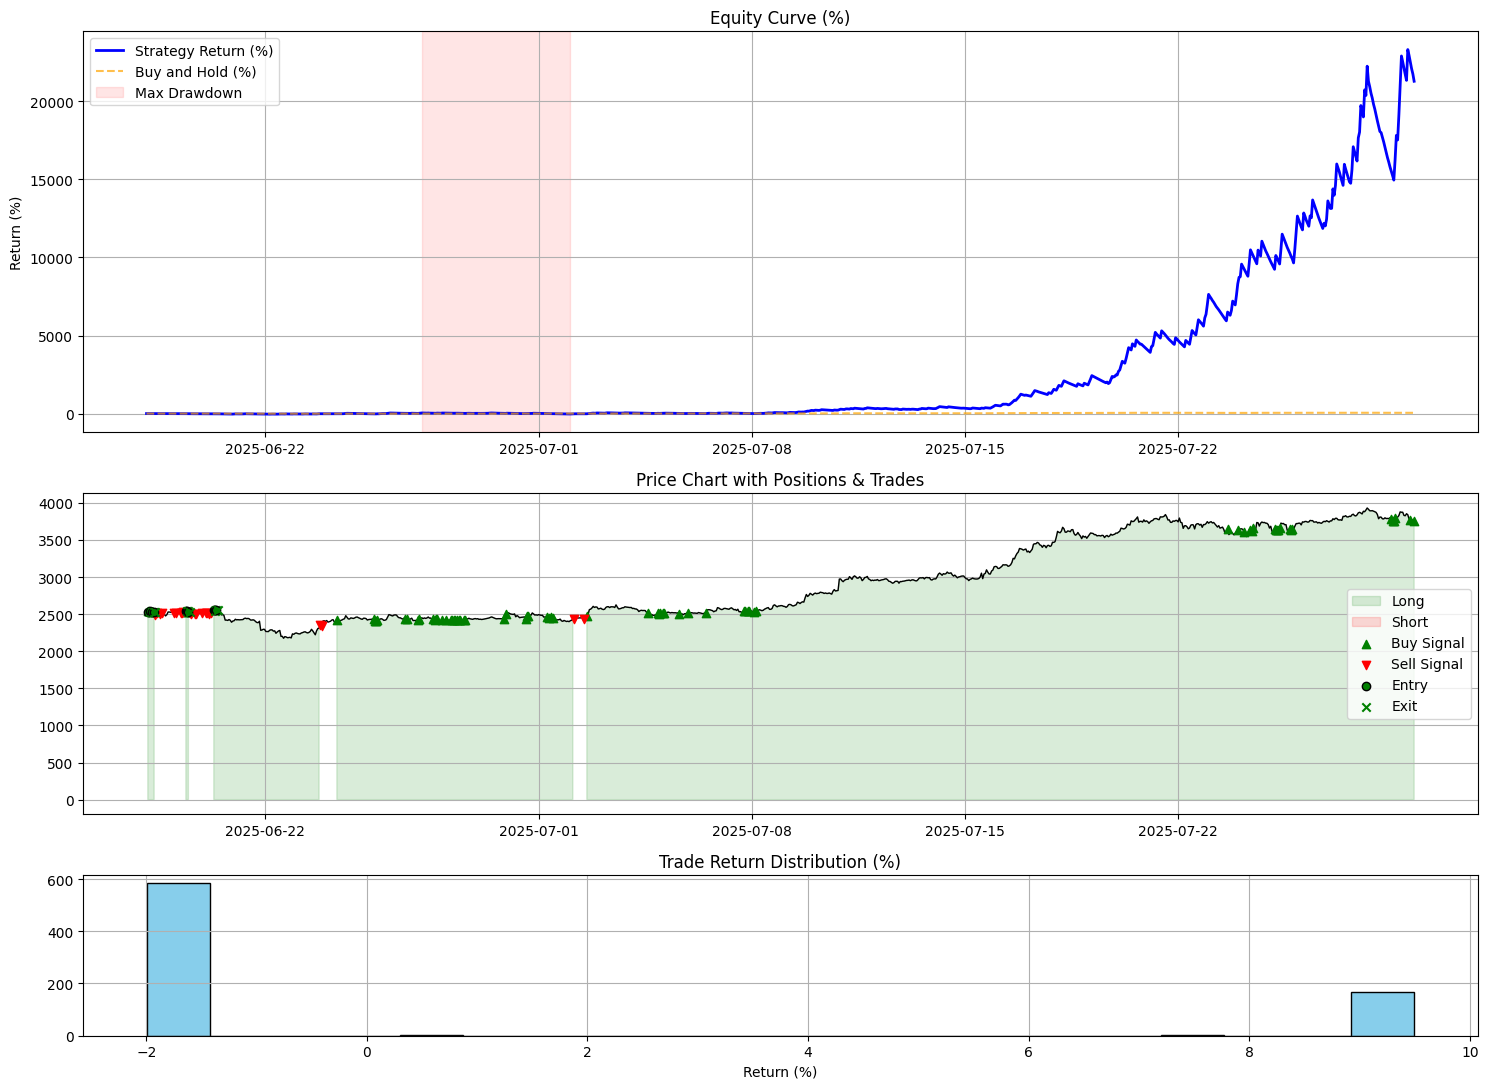

In [1]:
from Technicalindicatorstrategy import vegas
from Backtest.backtest import backtest_signals
from Plot.plot import plot_backtest_result
import pandas as pd
from datetime import datetime
import warnings 
warnings.filterwarnings('ignore')

df_signals = vegas.get_signals('ETHUSDT','1h',datetime.now(),1000)

result = backtest_signals(
    df_signals.copy(),
    initial_capital = 33, # 1000台幣
    fee_rate = 0.0005, # 合約手續費
    leverage = 10, # 槓桿
    allow_short = False, # 是否做空
    stop_loss = 0.001,       # 停損閾值，例如0.05代表5%
    take_profit = 0.01,     # 停利閾值
    capital_ratio = 1, # 每次使用的資金佔比
    max_hold_bars = 1000)  # 最大持有K棒數
display(pd.DataFrame(result['metric'],index=['metric']).T)
plot_backtest_result(result)

100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


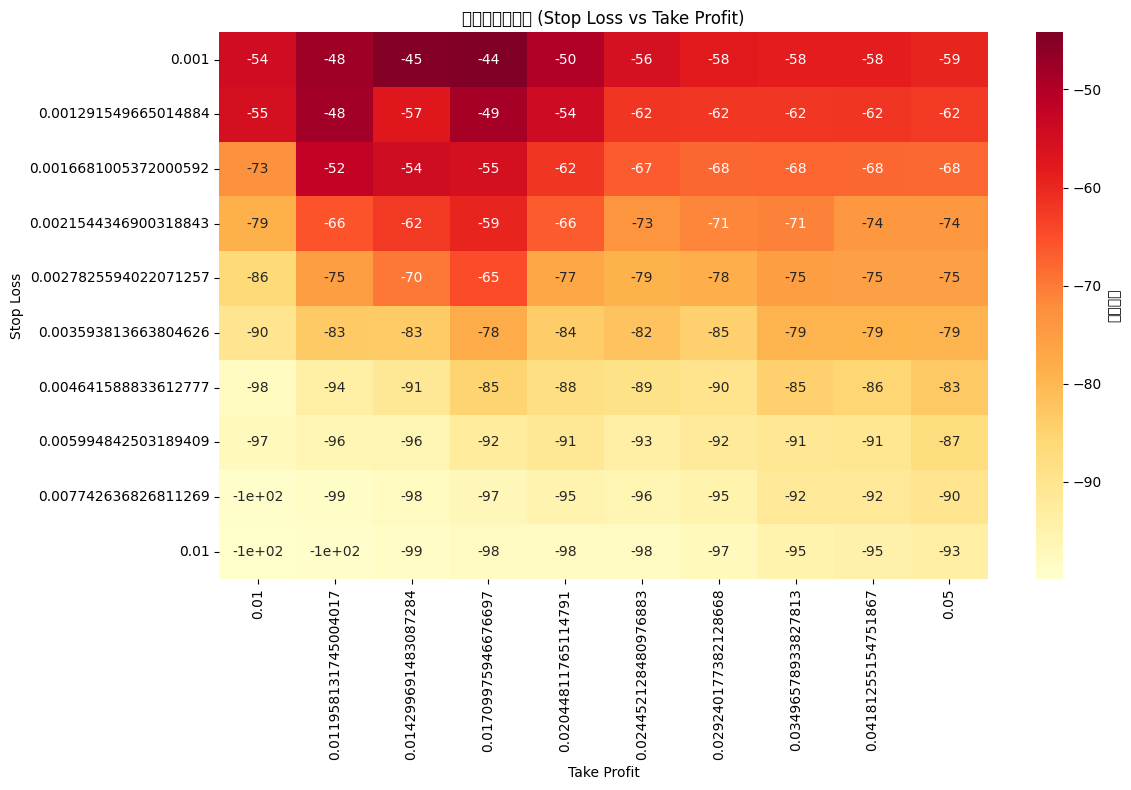

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# 設定 stop_loss 與 take_profit 的範圍
stop_losses = np.geomspace(0.001, 0.01, 10)
take_profits = np.geomspace(0.01, 0.05, 10)

# 用於儲存最大回撤結果
drawdown_matrix = pd.DataFrame(index=stop_losses, columns=take_profits)

# 跑backtest
for sl in tqdm(stop_losses):
    for tp in tqdm(take_profits):
        result = backtest_signals(
            df_signals.copy(),
            initial_capital=33,
            fee_rate=0.0005,
            leverage=10,
            allow_short=False,
            stop_loss=sl,
            take_profit=tp,
            capital_ratio=1,
            max_hold_bars=1000
        )
        max_drawdown = result['metric'].get('最大回撤', np.nan)
        drawdown_matrix.loc[sl, tp] = max_drawdown

# 轉為 float 類型（若是字串的話）
drawdown_matrix = drawdown_matrix.astype(float)

# 畫出熱力圖
plt.figure(figsize=(12, 8))
sns.heatmap(drawdown_matrix, annot=True, cmap="YlOrRd", cbar_kws={'label': '最大回撤'})
plt.title("最大回撤熱力圖 (Stop Loss vs Take Profit)")
plt.xlabel("Take Profit")
plt.ylabel("Stop Loss")
plt.tight_layout()
plt.show()
